In [1]:
import sys
sys.path.insert(1, "/home/user/work/")

import torch
from torchmetrics import R2Score
from matplotlib import pyplot as plt

from src.data import build_dataloader
from src.models import RegressionModel, BayesRegressionModel, MLPModel, BetaVAEModel
from src.trainer import Trainer

## Part 2: Machine Learning ##

As with the previous task, Jupyter notebooks usually wouldn't be used (e.g. see on of my public repos https://github.com/thomasgho/PECAN-pytorch). However, due to the nature of the questions, a notebook is convenient.

### Task 2.2  ###
#### (task 2.1 was included in Part 1) ####
For this task, two models are investigated: a baseline linear regression model and a Bayesean regression model.

Before exploring more complex models, beginning with simple models is useful for a few reasons:
- we can set a baseline (often at low cost) from which subsequent models can be evaluated against 
- we can gauge how far the simple assumtions take us, and in turn, learn which of our initial assumptions may be wrong
- we can iterate and monitor improvement in an explicit fashion

A Bayesean linear model was chosen due to its more explicit treatment of uncertainty, which may be useful in medical contexts (and due to personal interest in Bayesean methods). This is done by learning a distribution of possible model parameters via inference on a prior (which we could choose smartly if we had 'expert' information, but for now will be a standard Gaussian), concretely the conditional distribution of the weights given the training data. With an extension, this can be made into a Bayesian neural network too.

Both models (as well as the `Trainer` module) are coded from scratch using PyTorch (see `src/models/linear.py`, `src/models/bayes_linear.py`, and `src/trainer.py`). In retrospect, this task could have been easily done using sklearn's API, but the goal was to make a unified interface for this analysis (along with the deep learning section). Otherwise, random forests could also have been easily investigated (which seem to be the standard for gene/organoid tasks in my current company).

**Note on hyperparameters:** In general, the hyperparemeters that could be selected in this task include: SGD learning rate, L2 regualrization (or L1 with a few extra lines of code). Due to limited computational resource, hyperparameter optimization couldn't be conducted (which I usually conduct with Bayesian optimization using the Optuna package - which requires many training trails). If interested, example code for such a scheme is:

```
import optuna

def objective(trial):
    
    optimizer_params = {
        "lr": trial.suggest_loguniform("lr", 1e-4, 1e-2),
        "weight_decay": trial.suggest_loguniform("weight_decay", 1e-4, 1.),
    }

    # model instance
    model = RegressionModel(
        in_dim=4001,
        out_dim=1,
    )
    
    # optimizer instance
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=optimizer_params["lr"],
        weight_decay=optimizer_params["weight_decay"],
    )
    
    # metric instance
    metric = R2Score(multioutput='uniform_average')

    # train routine instance
    trainer = Trainer(
        model = model,
        optimizer = optimizer,
        metric = metric,
        patience = 10,
        accumulation_steps = 1,
        log_dir = "/home/user/work/runs/linear",
        cuda = True,
        mixed_precision = False,
    )

    # run train routine
    trainer.fit(
        train_loader,
        test_loader,
        100,
    )

    return trainer.fit_accuracy()

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

```

Due to the relatively large size of the dataset, initially the model was run without L2 regularization. Preliminary runs for the linear regression model with L2 regualarization didn't show significant difference, however this is better investigated quantitivly with more time and computational resource.  

### Task 2.3 ###

The R-squared score is used as the regression metric, which computes the ratio of the sum of squares and the total sum of squares for the predicted and true values. Broadly, it can tell us the extent to which the variation in the dependent variable can be attributed to the model. 1 is a perfect score, and negative scores are possible if the model is predicting worse than the mean of the target values. Closer to 1 indicates stronger correlation.

The best practice for evaluation is *k-fold cross validation*, which would have simple execution with sklearn's API. Having coded the data loading scheme on PyTorch's bleeding edge torchdata package (for some reason..), the task required more time than anticipated and is regrettably left unimplemented. However, the development of a native pytorch module for k-fold dalaloader preparation should be possible, and would be useful as it would generalize to other tasks too.

As a result, the approach used here is fairly standard but less robust. A train-test random split is used (80-20), the test is held-out to simulate how the model would perform on unseen data. Early stopping (with a patience parameter) was implemented, whereby the test loss was monitored for e.g. decrease -> increase. The model is checkpointed at each epoch (use `checkpoint=True` in Trainer instance), so the model can be recovered for the best performing epoch on the test set. Tensorboard is used to monitor loss curves (all of which is saved in `runs/` folder).

*Even better* would be a train-test-validation split (e.g. 60-20-20) (because, if I was to go through the end-to-end process of hyperparameter optimization and model tuning, the test metric may have influenced the creation of the final model. As a result, it is important to check if the final model is also overfitting to the test set, by evaluating the performance on a validation set. In this sense, a test set is just a evaluation of the model during the training process, and the validation set an evaluation of the final model.). However, since I was limited to go through the process of hyperparameter optimization and iteratively training/tweaking the model etc., I have not made a validation set for this task.

For classification tasks, metrics would be modified (e.g AUCROC for balanced datasets or AUCPR for imbalanced datasets). In the healthcare industry, however, it is of great importance to understand the the requirement/goal of the task (e.g. screening, drug delivery etc.). Often, generic metric such as the above may not fit the requirement - e.g. hospitals may particularly require a certain False Negative or False Positive rate (some previous projects in my current company have highlighted this). Maximum liklihood estimates via binary cross entropy loss may not directly correlate to models that meet clinical requirements. Therefore, evaluation stratagies must be sharply focused for the task at hand.

In [2]:
# load data
PATH = "/home/user/work/data/preprocessed/tgca_preprocessed.csv"
train_loader, test_loader, test_loader_unbatched = build_dataloader(PATH, batch_size=64)

In [3]:
# Linear regression

# model instance
linear_model = RegressionModel(
    in_dim=4001,
    out_dim=1,
)

# optimizer instance
optimizer = torch.optim.SGD(
    linear_model.parameters(),
    lr=1e-3,
    weight_decay=0.01,
)

# metric instance
metric = R2Score(multioutput='uniform_average')

# train routine instance
trainer = Trainer(
    model = linear_model,
    optimizer = optimizer,
    metric = metric,
    patience = 10,
    accumulation_steps = 1,
    log_dir = "/home/user/work/runs/linear",
    cuda = True,
    checkpoint = False,
    mixed_precision = False,
)

# run train routine
trainer.fit(
    train_loader,
    test_loader,
    100,
)

Epoch 0: 
             -> Train Loss = 272.957733532614 
             -> Test Loss = 128.94611623210292 
             -> Train Metric = -4.157792942583068 
             -> Test Metric = -1.4184050963770958
Epoch 1: 
             -> Train Loss = 65.65380096435547 
             -> Test Loss = 47.08802075539866 
             -> Train Metric = -0.2499621761731865 
             -> Test Metric = 0.1185305945334896
Epoch 2: 
             -> Train Loss = 25.966843132145147 
             -> Test Loss = 28.96450227306735 
             -> Train Metric = 0.5074129552880594 
             -> Test Metric = 0.4572408929947884
Epoch 3: 
             -> Train Loss = 17.759168632759536 
             -> Test Loss = 23.258736395066784 
             -> Train Metric = 0.6631023928153613 
             -> Test Metric = 0.5628034683965868
Epoch 4: 
             -> Train Loss = 15.450707892741054 
             -> Test Loss = 22.95756349255962 
             -> Train Metric = 0.7080123715164247 
             -> Te

The final metric is approx ~0.6. This would indicate that slighly more than half of the dependent variable variance (outcomes) is explained by the model’s independent variables (genes + treatment).

In [4]:
# Bayesian linear regression

# model instance
bayes_linear_model = BayesRegressionModel(
    in_dim=4001,
    out_dim=1,
    mu=0., 
    sigma=0.01, 
    bias=True,
)

# optimizer instance
optimizer = torch.optim.SGD(
    bayes_linear_model.parameters(),
    lr=1e-3,
)

# metric instance
metric = R2Score(multioutput='uniform_average')

# train routine instance
trainer = Trainer(
    model = bayes_linear_model,
    optimizer = optimizer,
    metric = metric,
    patience = 10,
    accumulation_steps = 1,
    log_dir = "/home/user/work/runs/bayes_linear",
    cuda = True,
    mixed_precision = False,
)

# run train routine
trainer.fit(
    train_loader,
    test_loader,
    100,
)

Epoch 0: 
             -> Train Loss = 278.38944338964035 
             -> Test Loss = 130.56454984603388 
             -> Train Metric = -4.268285175985541 
             -> Test Metric = -1.3370559446273311
Epoch 1: 
             -> Train Loss = 77.61937303779538 
             -> Test Loss = 61.12683363883726 
             -> Train Metric = -0.31141740132954493 
             -> Test Metric = 0.06820717165547033
Epoch 2: 
             -> Train Loss = 42.21143544409886 
             -> Test Loss = 46.92126784786101 
             -> Train Metric = 0.44490886769018884 
             -> Test Metric = 0.38443846471848026
Epoch 3: 
             -> Train Loss = 35.32963189999919 
             -> Test Loss = 42.13086331275202 
             -> Train Metric = 0.6129531407159222 
             -> Test Metric = 0.5013807396734914
Epoch 4: 
             -> Train Loss = 33.31684344268042 
             -> Test Loss = 39.94357422859438 
             -> Train Metric = 0.6699569501167486 
             -> 

### Task 2.4 ###

Since the R2 score requires more than one sample to be evaluated, (and the task is to evaluate the errors on a sample-wise level), we'll use the MSE loss, which is interperable as an error by construction. 

In [5]:
# evaluation mode
linear_model.eval()

# record predictions
patient_ids = []
losses = []

for data in test_loader_unbatched:

    # send tensors to device
    feats = data["feats"].to('cuda')
    outcome = data["outcome"].to('cuda')
    patient_id = data["ID"].to('cuda')
    
    # prediction
    pred_outcome = linear_model(feats).view(-1)
    
    # error
    loss = linear_model.loss(pred_outcome, outcome)
                
    # append to list
    patient_ids.append(patient_id.item())
    losses.append(loss.item())

    
# sort for highest errors
sorted_list = [("patient {}".format(int(ID)), "MSE error: {}".format(error))
 for error, ID in sorted(zip(losses, patient_ids), key=lambda pair: pair[0], reverse=True)]

# top N highest errors in test set
N = 20
print("Top {} largest errors in test set:".format(N))
for i in sorted_list[:N]:
    print(i)

Top 20 largest errors in test set:
('patient 9366', 'MSE error: 365.75518798828125')
('patient 5345', 'MSE error: 346.8134765625')
('patient 4714', 'MSE error: 316.36944580078125')
('patient 9123', 'MSE error: 310.2079162597656')
('patient 17', 'MSE error: 297.7361755371094')
('patient 801', 'MSE error: 293.6958312988281')
('patient 4288', 'MSE error: 264.23614501953125')
('patient 6002', 'MSE error: 246.2074432373047')
('patient 2706', 'MSE error: 210.23458862304688')
('patient 2313', 'MSE error: 196.68234252929688')
('patient 8547', 'MSE error: 192.17105102539062')
('patient 4650', 'MSE error: 191.846923828125')
('patient 6833', 'MSE error: 190.8087615966797')
('patient 8443', 'MSE error: 183.5873565673828')
('patient 5620', 'MSE error: 183.02999877929688')
('patient 6689', 'MSE error: 180.988037109375')
('patient 9638', 'MSE error: 179.9612274169922')
('patient 4488', 'MSE error: 177.12918090820312')
('patient 4049', 'MSE error: 173.9501495361328')
('patient 8413', 'MSE error: 172.5

### Task 2.5 ###

Modelling uncertainty is non-trivial, as it could take different forms (e.g uncertainty due to inherent limitation of the model, uncertainty from data quality limitations / representation / featurisation etc.), all of which can interact in non-trivial ways. On one level, say we assume that all data samples are drawn from a single distribution. Optimization schemes navigate complex loss landscapes (and in general, problems do not possess exact solutions), so using different hyperparameters / optimization schemes may lead to different solutions. On another level, say we assume each data sample may itself be drawn from an individual distribution (which are often assumed independent, but can have covariance). Then, instead of a single model, we would have a distribution of models.

Cross validation schemes can provide a noisy estimates (e.g. an emperical distribution of cross validation scores can be built). We can fit a model with each validation set held out, evaluate each model on its corresponding held-out set, and average the k error estimates. As a result, an unbiased estimate of the test error (with lower variance than a single train-validation split) can be aquired. Bootstrapping schemes xan also provide predictions for out-of-fold test data samples, and aggregating estimates across bootstrap samples can let us get estimates of prediction variance. Other methods could include computing ensembles of models instead of a single estimator (or e.g. random forests consisting of individual decision trees are already ensembles by design, hence the ensemble variance can be taken as their default uncertainty measure.) etc.

When comparing two different model constructions, hypothesis tests for a difference in test error between two models can be used. Such a scheme would allow us to be confident that a model's test erroris better than a baseline or an available alternative.

As mentioned previously, a Bayesian regression was performed to model intrinsic uncertainty across parameters via inference. We could interpret this learning a family of models and giving them different weights according to their likelihood of being correct. The forward computation (i.e. sampling) for a given data point allows us to aquire a distribution of outcomes.

### Task 2.6 ###
Plotting largest weights/coefficient can help gauge feature importance for linear model. It is left unimplemented due to timing :(

### Task 2.7 ###

Continuing the theme of Bayesean learning, the model used here is a variational autoencoder with an additional component (a jointly learnt 'outcome prediction' network conditioned on treatment). Via principled approximate inference, the idea is to build latent representations of samples. Stochasticity (in this case, a simple Gaussian prior adding noise to latent variables), allows robust representations to decode (in a space which, we hope, we can interpolate and find 'interpretable' directions/structure in). Optimistically, we hope to build a structured, lower dimensional latent space in which like-gene features are clustered, and from which we can sample from.

The motivation is twofold; 1) via variational inference, we hope to build a flexible enough lower dimensional distribution encoding the data (we can perhaps improve this with better prior knowledge than a simple Gaussian, or use invertible transformations to transform such priors into more flexible, non-trivial distributions (normalizing flows)) from which a jointly trained predictor network branches from 2) we can build a structured space which we can annotate and sample from to generate new data (e.g. addressing the missing data problem, or data privacy problem).

The implemented model is rather simple, a baseline VAE (ResNet encoder/decoder) with a Gaussian prior encoding *only* the gene features, and a branched 2 layer MLP predicting the outcome from the latent representation and *conditioned* on the treatment. With more knowledge on the data itself, an exploration of the latent space would be interesting, as well as the possibility to build a better suited model. The model was built from scratch (`src/models/vae.py`).

(Given more time, a simple β-VAE was planned to be investigated for different β. But for now β=1)

As mentioned, the below would benefit from hyperparameter tuning (currently hyperparameters have been set somewhat arbitrarily due to limitation in computational environment and time.) It seems it needs heavier regularization...

In [7]:
# VAE

# model instance
vae_model = BetaVAEModel(
    in_dim=4000,
    out_dim=1,
    z_dim=30,
    hidden_dim=64,
    context_dim=1,
    num_blocks=2,
    batch_norm=True,
)

# optimizer instance
optimizer = torch.optim.AdamW(
    vae_model.parameters(),
    lr=1e-3,
    weight_decay=0.05,
)

# metric instance
metric = R2Score(multioutput='uniform_average')

# train routine instance
trainer = Trainer(
    model = vae_model,
    optimizer = optimizer,
    metric = metric,
    patience = 5,
    accumulation_steps = 1,
    log_dir = "/home/user/work/runs/vae",
    cuda = True,
    mixed_precision = False,
    is_vae = True,
)

# run train routine
trainer.fit(
    train_loader,
    test_loader,
    100,
)

Epoch 0: 
             -> Train Loss = 470.20679265802556 
             -> Test Loss = 435.9672438098538 
             -> Train Metric = -7.874867778179074 
             -> Test Metric = -7.126083004859186
Epoch 1: 
             -> Train Loss = 410.6526834787416 
             -> Test Loss = 362.2986912881174 
             -> Train Metric = -6.744130879394279 
             -> Test Metric = -5.7381952654930855
Epoch 2: 
             -> Train Loss = 326.9078965620561 
             -> Test Loss = 277.49088016633067 
             -> Train Metric = -5.17457025110229 
             -> Test Metric = -4.138283806462442
Epoch 3: 
             -> Train Loss = 221.80927963887365 
             -> Test Loss = 172.51383775280368 
             -> Train Metric = -3.160432242164927 
             -> Test Metric = -2.1865082786929224
Epoch 4: 
             -> Train Loss = 136.69681536461695 
             -> Test Loss = 101.67549650130734 
             -> Train Metric = -1.5697205559281278 
             -> 

A visual of the latent space for the test set is provided below. It seems while the VAE found some structure, it is uncorrelated with treatment scheme. (If treatment was used directly as input into the encoder (rather than just a conditional to the predictor network), there perhaps may have been more correlation).

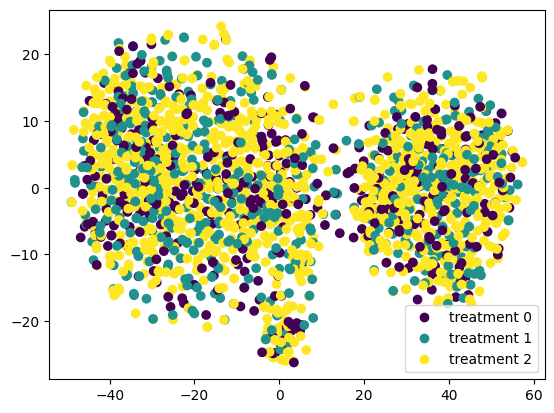

In [8]:
from sklearn.manifold import TSNE

# evaluation mode
vae_model.eval()

# record latent vectors
latent_vectors = []
treatments = []

for data in test_loader_unbatched:

    # send tensors to device
    feats = data["feats"].to('cuda')
    treatment = data["treatment"]
    
    # latent vector prediction
    latent_vector = vae_model.latent_space(feats[:, :-1])
                
    # append to list
    latent_vectors.append(latent_vector.cpu())
    treatments.append(treatment.item())

# to numpy    
latent_vectors = torch.cat(latent_vectors).detach().numpy()

# compute TSNE
tsne = TSNE(n_components=2, random_state=0)
latent_vectors_2d = tsne.fit_transform(latent_vectors)

# plot
plt.figure()
scatter = plt.scatter(latent_vectors_2d[:,0], latent_vectors_2d[:,1], c=treatments)
labels = ["treatment 0", "treatment 1", "treatment 2"]
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)